# Random seed setting & Dependency installing

In [1]:
%%capture
%pip install transformers torchvision ultralytics accelerate

In [2]:
import random
import numpy as np
import pandas as pd
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, ImageDraw
from io import BytesIO
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import matplotlib.patches as patches
from tqdm.auto import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2


seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Data preparation

In [4]:
BASE_PATH = '/kaggle/input/ddd-dataset'

In [5]:
train_df = pd.read_csv(BASE_PATH + '/train (1).csv')
test_df = pd.read_csv(BASE_PATH + '/test (1).csv')

In [6]:
train_df.head()

,image_id,file_name,height,width,category_name,bb1,bb2,bb3,bb4,data_id
0,1,equestrian/006_14295751692.jpg,533,799,railings being crossed by horses,3,218,796,315,1
1,1,equestrian/006_14295751692.jpg,533,799,a horse running or jumping,247,118,293,415,2
2,1,equestrian/006_14295751692.jpg,533,799,equestrian rider's helmet,377,59,39,50,3
3,4,equestrian/009_3468912962.jpg,800,531,equestrian rider's helmet,143,113,71,130,4
4,5,equestrian/011_3468099779.jpg,800,531,equestrian rider's helmet,143,112,71,131,5


## Image normalization

In [7]:
class ImageTitleDataset(Dataset):
    def __init__(self, df, train=True, transform=None):

        self.image_id = df['image_id'].values
        self.category_name = df['category_name'].values
        self.train = train
        self.base_path = BASE_PATH
        self.bbox = df[['bb1', 'bb2', 'bb3', 'bb4']].values
        self.width = df['width'].values
        self.height = df['height'].values
        

    def __len__(self):
        return len(self.image_id)

    def __getitem__(self, idx):
        image_id = self.image_id[idx]
        if self.train:
          img_path = self.base_path + '/data/train/' + str(image_id) + '.jpg'
        else:
          img_path = self.base_path + '/data/test/' + str(image_id) + '.jpg'
        width = self.width[idx]
        height = self.height[idx]
        size = [width, height]
        cata = self.category_name[idx]
        bbox = self.bbox[idx]


        return {'cata': cata, 'image_id':image_id, 'size':size,'ori_bbox': bbox}

In [8]:
train_set = ImageTitleDataset(train_df,train=True, transform=None)
test_set = ImageTitleDataset(test_df, train=False, transform=None)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [9]:
sample_train = next(iter(train_loader))

## Sample data

In [10]:
def draw_bounding_boxes(image, bbox, label):
    fig, ax = plt.subplots(1)
    image_np = image
    ax.imshow(image_np)
    rect = patches.Rectangle(
            (bbox[0].item(), bbox[1].item()), bbox[2].item(), bbox[3].item(),
            linewidth=2, edgecolor='r', facecolor='none'
        )
    ax.add_patch(rect)
    plt.text(bbox[0].item(), bbox[1].item(), 'Ground Truth', bbox={'facecolor': 'red', 'alpha': 0.5})
    print(label)
    plt.show()

lights on in the room


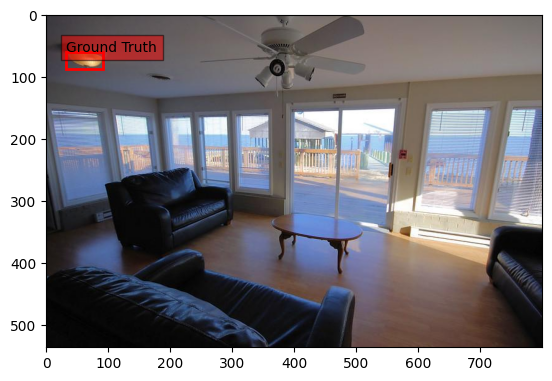

In [11]:
idx = random.randint(0, len(sample_train['image_id']))
image_id = sample_train['image_id'][idx]
image_path = f"/kaggle/input/ddd-dataset/data-20240704T180513Z-001/data/train/{image_id}.jpg"
image = Image.open(image_path).convert('RGB')
bbox = sample_train['ori_bbox'][idx]
label = sample_train['cata'][idx]
draw_bounding_boxes(image, bbox, label)
image_id = sample_train['image_id'][idx].item()

# YoloWorld & Spcay -- Overview

In [12]:
%%capture
%pip install -q inference-gpu[yolo-world]==0.9.12rc1
%pip install supervision
from inference.models.yolo_world.yolo_world import YOLOWorld
import supervision as sv
import cv2

a toy other than human toys


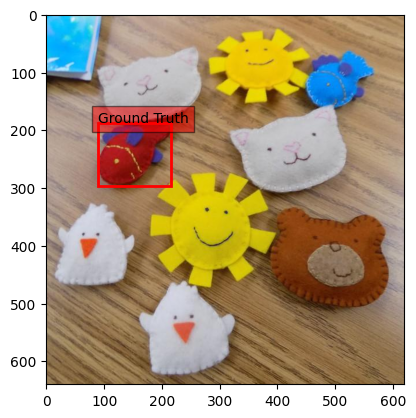

a det
toy ROOT
other amod
than prep
human amod
toys pobj
root: toy


100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 103MiB/s]


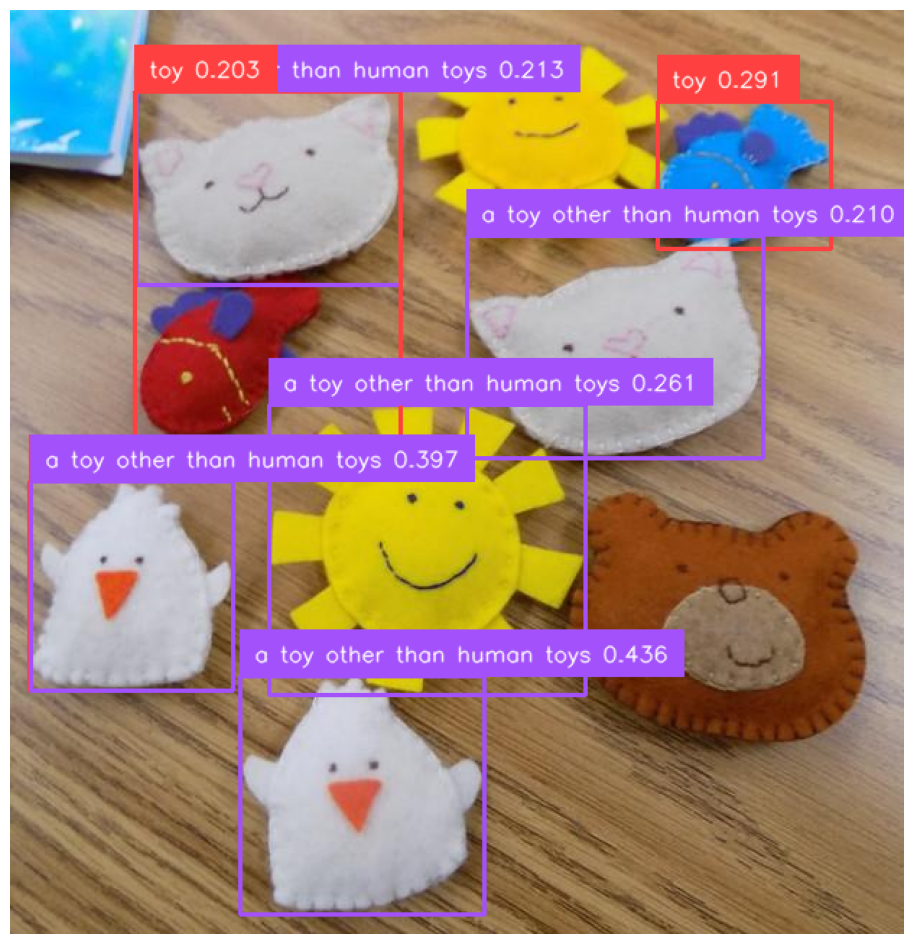

In [13]:
import spacy
from nltk import Tree

#----------- Data Sampling ----------------#


idx = random.randint(0, len(sample_train['image_id']))
image_id = sample_train['image_id'][idx]
image_path = f"/kaggle/input/ddd-dataset/data-20240704T180513Z-001/data/train/{image_id}.jpg"
image = Image.open(image_path).convert('RGB')
bbox = sample_train['ori_bbox'][idx]
label = sample_train['cata'][idx]
draw_bounding_boxes(image, bbox, label)
bbox_ori = sample_train['ori_bbox'][idx]


#----------- Text Preprocessing -----------#

en_nlp = spacy.load('en_core_web_sm')

doc = en_nlp(label)

def to_nltk_tree(node):
    if node.n_lefts + node.n_rights > 0:
        return Tree(node.orth_, [to_nltk_tree(child) for child in node.children])
    else:
        return node.orth_

sentence = next(doc.sents)
for word in sentence:
  print(word,word.dep_)
  if word.dep_ == 'ROOT':
    root = str(word)

print('root: '+ root)



#------------- Detection -----------------#

model = YOLOWorld(model_id="yolo_world/l")

classes = [label, root]
model.set_classes(classes)

results = model.infer(image, confidence=0.2)
detections = sv.Detections.from_inference(results)
pred_bbox = detections.xyxy[0]

labels = [
    f"{classes[class_id]} {confidence:0.3f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]


annotated_image = image.copy()
annotated_image = sv.BoundingBoxAnnotator().annotate(annotated_image, detections)
annotated_image = sv.LabelAnnotator().annotate(annotated_image, detections, labels=labels)
sv.plot_image(annotated_image)

In [14]:
pred_bbox

array([     159.85,      461.22,      328.23,       626.8])

# CLIP -- Overview

We can use CLIP to do obj detection by splitting image into many small patches and calculate score of each patch with the expression txt. However, it's quit slow and depend on the resolution of the image becuse if image is small the size of patch cannot be a certain size which will have much infomation for CLIP to understand if it relates to the txt or not.

In [15]:
pip install --upgrade urllib3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.4/121.4 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.18
    Uninstalling urllib3-1.26.18:
      Successfully uninstalled urllib3-1.26.18
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
distributed 2024.1.1 requires dask==2024.1.1, but you have dask 2024.5.2 which is incompatible.
kfp 2.5.0 requires google-cloud-storage<3,>=2.2.1, but you have google-cloud-storage 1.44.0 which is incompatible.
kfp 2.5.0 requires requests-toolbelt<1,>=0.8.0, but you have requests-toolbelt 1.0.0 which is incompatible.
kfp 2.5.0 requires urllib3<2.0.0, but you have urllib3 2.2.2 which is incompatible.
rapids-dask-dependency 24.4.1a0 requires dask==2024.1.1, but you have dask 2024.5.2 which is incompati

In [16]:
from transformers import CLIPProcessor, CLIPModel


model_id = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(model_id)
clip_processor = CLIPProcessor.from_pretrained(model_id)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
clip_model.to(device)

def get_patches(image, patch_size=256):
    transform = transforms.ToTensor()
    img_tensor = transform(image).unsqueeze(0)
    print(img_tensor.shape)
    patches = img_tensor.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    return patches

def create_big_patches(patches, patch_size=256, window=6, stride=1):
    big_patches = []
    for Y in range(0, patches.shape[2]-window+1, stride):
        for X in range(0, patches.shape[3]-window+1, stride):
            big_patch = torch.zeros((3, patch_size*window, patch_size*window))
            patch_batch = patches[0, :, Y:Y+window, X:X+window]
            for y in range(window):
                for x in range(window):
                    big_patch[:, y*patch_size:(y+1)*patch_size, x*patch_size:(x+1)*patch_size] = patch_batch[:, y, x]
            big_patches.append(big_patch)
    return big_patches


def calculate_similarity(big_patches, description, model, processor, device='cpu'):
    scores = []
    for big_patch in big_patches:
        inputs = processor(
            images=transforms.ToPILImage()(big_patch),
            return_tensors="pt",
            text=[description],
            padding=True
        ).to(device)
        with torch.no_grad():
            score = model(**inputs).logits_per_image.item()
        scores.append(score)
    return scores

def visualize_relevance_map(image, scores, patch_size=256, window=6, stride=1):
    H, W = image.size
    heatmap = np.zeros((H, W))
    score_index = 0
    for Y in range(0, H-patch_size*window+1, stride*patch_size):
        for X in range(0, W-patch_size*window+1, stride*patch_size):
            heatmap[Y:Y+patch_size*window, X:X+patch_size*window] = scores[score_index]
            score_index += 1

    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)
    ax.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.show()


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [17]:
image_path = f"/kaggle/input/ddd-dataset/data-20240704T180513Z-001/data/train/{image_id}.jpg"
image = Image.open(image_path).convert('RGB')

# Set parameters
patch_size = 32
window = 6
stride = 1
description = label

patche = get_patches(image, patch_size)

torch.Size([1, 3, 640, 619])


As the below result, this method not that good for recognizing the flower

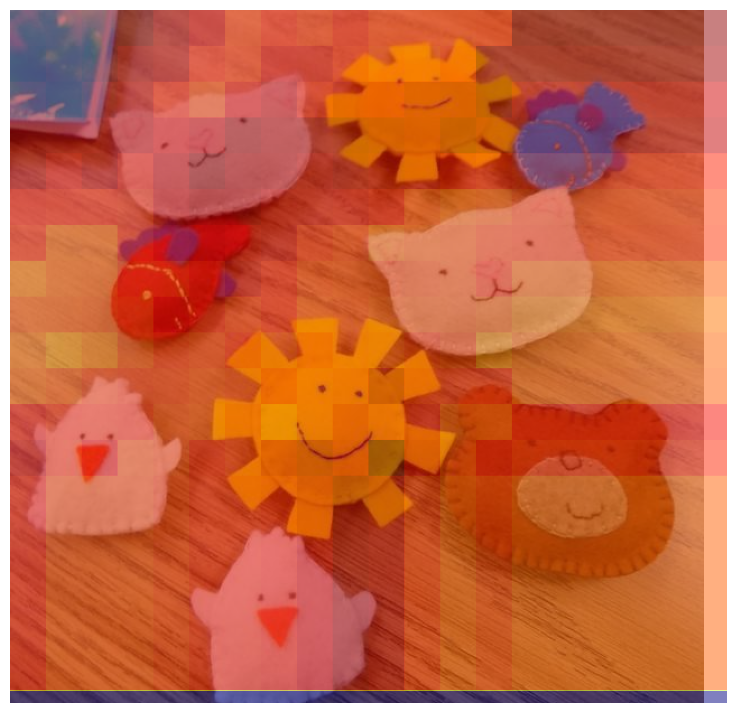

In [18]:
big_patches = create_big_patches(patche, patch_size, window, stride)
scores = calculate_similarity(big_patches, description, clip_model, clip_processor, device)
visualize_relevance_map(image, scores, patch_size, window, stride)

# Data cleaning

Some text expressions are not obj related that much. So, we will try using spacy for embeding them and do clustering

## Pre processing texts

In [19]:
all_expression = train_df['category_name'].unique()

expression_embeddings = []
for expression in all_expression:
  tokenized = en_nlp(expression)
  expression_embeddings.append(tokenized.vector)

In [20]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

clsr = KMeans()
clsr.fit(expression_embeddings)
label = clsr.labels_

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7bf6039cbb50>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 847, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 984, in _make_controller_from_path
    lib_controller = controller_class(filepath=filepath, prefix=prefix)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 111, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/opt/conda/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /opt/conda/lib/python3.10/site-packages/numpy.libs/libopenblas64_p-r0-0cf96a72.3.23.dev.so: cannot open shared object file: No such file or directory


In [21]:
reduced_embeddings = TSNE(n_components=2).fit_transform(np.array(expression_embeddings))

In [22]:
label_expession = []
for i in zip(label, all_expression, reduced_embeddings):
  row_ = {}
  row_['expression'] = i[1]
  row_['label'] = i[0]
  row_['x'] = i[2][0]
  row_['y'] = i[2][1]
  label_expession.append(row_)

In [23]:
label_expession = pd.DataFrame(label_expession)

In [24]:
label_expession.label.unique()

array([7, 0, 4, 3, 6, 1, 2, 5], dtype=int32)

Our method can seperate the cluster quite well. This is a good sign that there are information in the embeding which can be use to diffrentiate our expression

## Investigating result

In [25]:
label_expession[label_expession['label'] == 0].sample(10)

,expression,label,x,y
221,camel not lying on the ground,0,-16.353926,9.649146
139,a person holding animals,0,12.484188,2.554218
137,a person who hugs another person but doesn't t...,0,-0.218690,21.323301
324,the woman who is hitting the ball in beach vol...,0,0.074143,14.423304
7,a dog being touched,0,5.920006,20.634342
171,a baseball player ready to bat,0,-2.222322,12.781281
104,a person being interviewed,0,5.912282,20.633904
98,a person who is fishing with a fishing rod,0,0.343961,16.802658
307,hippo whose mouth are not open,0,-5.015711,17.064194
265,helicopter not flying in the air,0,-16.275108,9.255907


person --> no

In [26]:
label_expession[label_expession['label'] == 1].sample(10)

,expression,label,x,y
30,a cat on the sofa,1,1.554220,2.181260
73,a plush toy,1,-9.746643,-16.032429
199,a person standing on the surfboard,1,6.553275,0.925150
213,a lion lying in the wild,1,7.146533,-0.019190
209,a person jumping into the pool,1,7.511367,1.452051
233,an auto-salon girl leaning against the car,1,-11.104743,7.149504
252,a plane flying to the right,1,7.447665,5.173860
262,a golfer in a hat,1,2.870026,4.489486
9,a basketball player with both feet off the ground,1,-0.099541,6.106736
32,a bed with patterns in the room,1,-4.538538,1.808837


mostly living --> no

In [27]:
label_expession[label_expession['label'] == 2].sample(10)

,expression,label,x,y
228,a giant panda on its four feet,2,-1.647221,7.335691
238,person in the lion dance clothes,2,-5.847706,5.811227
91,hanger without clothes,2,8.369422,8.915928
76,shopping cart full of goods,2,-10.363906,-1.509446
145,a person wearing santa claus clothes,2,13.820065,-0.784203
142,flowers in the hands of a woman in white skirt,2,-3.243335,4.171383
93,a piece of clothing worn on plastic models,2,-5.309519,8.291766
79,a mask on face with only eyes exposed,2,-3.845147,9.153046
132,a cable car without people inside,2,-6.091306,2.029388
248,a butterfly resting on flowers,2,5.484986,-3.786886


obj --> use

In [28]:
label_expession[label_expession['label'] == 3].sample(10)

,expression,label,x,y
188,indoor volleyball flying in the air,3,5.647656,-7.056058
20,pot with food,3,14.695206,13.307118
270,well cover without words on the surface,3,-11.869704,-9.007964
283,woodpecker not on the side of the trunk,3,-15.499714,0.148302
10,player with basketball in the hand,3,-3.784907,-7.427013
24,lights on in the room,3,2.643978,-1.462399
144,man in suit next to a woman in wedding dress,3,-2.371294,-9.555718
320,otter not in the water,3,-16.259331,1.358826
13,coffee cup with coffee,3,-1.187421,-14.622938
22,pot without food,3,14.707480,13.314459


obj --> use

In [29]:
label_expession[label_expession['label'] == 4].sample(10)

,expression,label,x,y
174,white football helmet,4,0.215775,-23.219574
6,clothed dog,4,-5.786523,-22.381205
281,crouching kangaroo,4,16.154816,-4.880147
2,equestrian rider's helmet,4,15.925262,7.700633
57,monochrome flowerpot,4,0.902157,-22.305264
150,written paper,4,-5.088797,-22.432951
161,white conference table,4,0.362791,-23.155134
273,red mailbox,4,-1.339317,-23.166792
278,running deer,4,15.538249,-7.903810
241,climber's helmet,4,16.097391,7.741590


 obj --> use

In [30]:
label_expession[label_expession['label'] == 5].sample(10)

,expression,label,x,y
293,half-body dolphin on the water,5,-12.712122,6.659304
224,red-crowned crane not standing on the ground,5,11.903857,-11.933514
53,vegetable-free hot dog,5,12.615484,-14.410208
156,an unoccupied chessboard,5,6.716800,-19.658659
219,a prone camel,5,-8.401020,-16.433067
223,red-crowned crane standing on the ground,5,11.770574,-12.100343
203,an empty swing bench,5,5.437881,-20.758642
226,red-crowned crane with head lower than body,5,10.505760,-12.832048
177,athlete wearing non-white stockings on the gre...,5,10.757052,-15.781610
200,an upside-down gymnast,5,-11.929301,5.475031


mix --> no 

In [31]:
label_expession[label_expession['label'] == 6].sample(10)

,expression,label,x,y
212,wild lioness,6,-0.609946,-20.425186
8,basketball untouched,6,2.373617,-15.772728
90,clothes hanger,6,-7.644678,7.093328
302,fake peacock,6,0.714620,-18.480389
48,incomplete donut,6,-3.076991,-17.983952
61,incomplete apple,6,0.346156,-18.739069
216,parrot eating,6,12.966591,-6.571068
49,chocolate donut,6,-3.482907,-17.649300
96,open package,6,-0.187884,-19.520372
95,backpack,6,-4.727466,-14.798507


obj --> use

In [32]:
label_expession[label_expession['label'] == 7].sample(10)

,expression,label,x,y
255,frisbee not held by anyone,7,-9.323472,19.916935
187,a red table tennis racket held by someone,7,-8.081838,11.953979
180,a tennis racket held by someone on the tennis ...,7,-8.107701,11.881732
167,a person trampled by cheerleaders,7,-10.138528,14.979070
5,outdoor dog led by rope,7,-12.696803,15.075932
231,car contacted by an auto-salon girl,7,-11.034637,7.951213
107,oven integrated with cabinet,7,9.549799,-10.425911
313,partially blocked moon,7,-10.876255,21.515799
271,mailbox marked with numbers,7,-11.761261,18.826059
100,a fish held by people,7,-9.961728,14.665755


ref --> not use

## Clusters than can be used

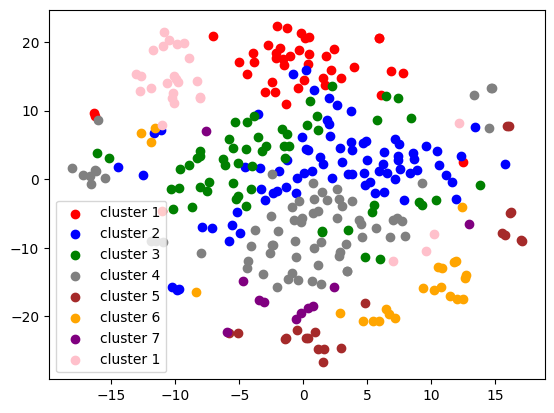

In [33]:
plt.scatter(label_expession[label_expession['label'] == 0]['x'], label_expession[label_expession['label'] == 0]['y'], c='red', label = 'cluster 1')
plt.scatter(label_expession[label_expession['label'] == 1]['x'], label_expession[label_expession['label'] == 1]['y'], c='blue', label = 'cluster 2')
plt.scatter(label_expession[label_expession['label'] == 2]['x'], label_expession[label_expession['label'] == 2]['y'], c='green', label = 'cluster 3')
plt.scatter(label_expession[label_expession['label'] == 3]['x'], label_expession[label_expession['label'] == 3]['y'], c='gray', label = 'cluster 4')
plt.scatter(label_expession[label_expession['label'] == 4]['x'], label_expession[label_expession['label'] == 4]['y'], c='brown', label = 'cluster 5')
plt.scatter(label_expession[label_expession['label'] == 5]['x'], label_expession[label_expession['label'] == 5]['y'], c='orange', label = 'cluster 6')
plt.scatter(label_expession[label_expession['label'] == 6]['x'], label_expession[label_expession['label'] == 6]['y'], c='purple', label = 'cluster 7')
plt.scatter(label_expession[label_expession['label'] == 7]['x'], label_expession[label_expession['label'] == 7]['y'], c='pink', label = 'cluster 1')
plt.legend()
plt.show()

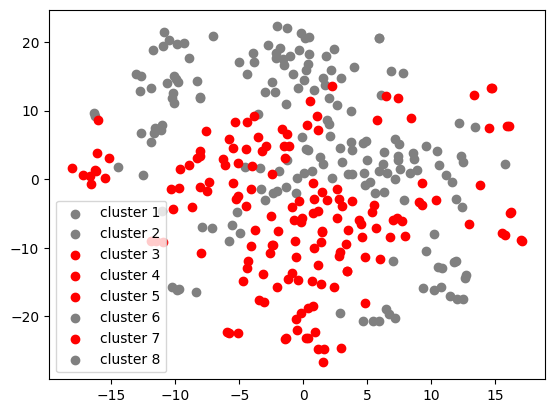

In [34]:
plt.scatter(label_expession[label_expession['label'] == 0]['x'], label_expession[label_expession['label'] == 0]['y'], c='gray', label = 'cluster 1')
plt.scatter(label_expession[label_expession['label'] == 1]['x'], label_expession[label_expession['label'] == 1]['y'], c='gray', label = 'cluster 2')
plt.scatter(label_expession[label_expession['label'] == 2]['x'], label_expession[label_expession['label'] == 2]['y'], c='red', label = 'cluster 3')
plt.scatter(label_expession[label_expession['label'] == 3]['x'], label_expession[label_expession['label'] == 3]['y'], c='red', label = 'cluster 4')
plt.scatter(label_expession[label_expession['label'] == 4]['x'], label_expession[label_expession['label'] == 4]['y'], c='red', label = 'cluster 5')
plt.scatter(label_expession[label_expession['label'] == 5]['x'], label_expession[label_expession['label'] == 5]['y'], c='gray', label = 'cluster 6')
plt.scatter(label_expession[label_expession['label'] == 6]['x'], label_expession[label_expession['label'] == 6]['y'], c='red', label = 'cluster 7')
plt.scatter(label_expession[label_expession['label'] == 7]['x'], label_expession[label_expession['label'] == 7]['y'], c='gray', label = 'cluster 8')
plt.legend()
plt.show()

In [35]:
used = [2, 3, 4, 6]
used_expression = label_expession[label_expession['label'].isin(used)]

In [36]:
used_expression = list(used_expression.expression.unique())

In [37]:
filtered_train = train_df[train_df['category_name'].isin(used_expression)]
msk = np.random.rand(len(filtered_train)) < 0.8
new_train = filtered_train[msk]
new_test = filtered_train[~msk]

In [38]:
class ImageTitleDataset(Dataset):
    def __init__(self, df, train=True, transform=None):

        self.image_id = df['image_id'].values
        self.category_name = df['category_name'].values
        self.train = train
        self.base_path = BASE_PATH
        self.transform = transform
        self.bbox = df[['bb1', 'bb2', 'bb3', 'bb4']].values
        self.width = df['width'].values
        self.height = df['height'].values
        self.file_name = df['file_name'].values


    def __len__(self):
        return len(self.image_id)

    def __getitem__(self, idx):
        image_id = self.image_id[idx]
        img_path = '/kaggle/input/ddd-dataset/data-20240704T180513Z-001/' + 'data/train/' + str(image_id) + '.jpg'
        width = self.width[idx]
        height = self.height[idx]
        original_size = (width, height)
        image = Image.open(img_path).convert('RGB')
        image = np.array(image)

        cata = self.category_name[idx]
        bbox = self.bbox[idx]
       

        return {'cata': cata, 'image_id':image_id, 'ori_bbox': bbox}

In [39]:
len(new_test)

1416

# Evaluation


In [40]:
def calculate_iou(box1, box2):
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    inter_width = max(0, x2_inter - x1_inter)
    inter_height = max(0, y2_inter - y1_inter)
    inter_area = inter_width * inter_height

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area if union_area > 0 else 0
    return iou

def evaluate_yolo(model, dataloader, confidence_threshold=0.2):
    ious = []

    for batch in tqdm(dataloader, desc="Evaluating"):
        images = batch['image_id']
        gt_bboxes = batch['ori_bbox']

        for i, image in enumerate(images):
            label = batch['cata'][i]
            image_path = f"/kaggle/input/ddd-dataset/data-20240704T180513Z-001/data/train/{batch['image_id'][i]}.jpg"
            image = Image.open(image_path).convert('RGB')
            # print(label)
            classes = [label]
            model.set_classes(classes)
            results = model.infer(image, confidence=confidence_threshold)
            detections = sv.Detections.from_inference(results).with_nms(threshold=0.01)

            idx = -1
            if len(detections.confidence) != 0:
                idx = detections.confidence.argmax()
                labels = [f"{detections.class_id[idx]} {detections.confidence[idx]:0.3f}"]
            else:
                labels = []


            gt_box = gt_bboxes[i]
            max_iou = []
            # print("gt:", gt_box)
            gt_box = [gt_box[0], gt_box[1], gt_box[2] + gt_box[0], gt_box[3] + gt_box[1]]

            
            for pred_box in detections.xyxy:
                # print(pred_box)
                iou = calculate_iou(pred_box, gt_box)
                max_iou.append(iou)
            
            if idx != -1:
                ious.append(max_iou[idx])
            else:
                ious.append(0)
                

    mean_iou = np.mean(ious)
    return mean_iou


In [41]:
test_set = ImageTitleDataset(new_test, train=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
mean_iou = evaluate_yolo(model, test_loader)
print(f'Mean IoU: {mean_iou:.4f}')

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]

Mean IoU: 0.3294


Predicting with pretrain low-nms YoLoworld with most confidence scheme give us Mean IoU: 0.3293

# Enhanced YoLo World with CLIP

As Yolo cannot much capture the surrounding context of the target. I will try adding CLIP model into process and train tem on the train set.

What we will do is to let Yolo predict many possible targets by using low nms then we will use CLIP to evaluate those predicted bbox and answer the hightest likly to be what the expression text input is

In [42]:
def compute_mean_std(image_paths):
    mean = torch.zeros(3)
    var = torch.zeros(3)
    to_tensor = transforms.ToTensor()

    # Calculate mean
    for image_path in tqdm(image_paths, desc="Calculating mean"):
        image = Image.open(image_path)
        image_tensor = to_tensor(image)
        mean += torch.mean(image_tensor, dim=(1, 2))

    mean /= len(image_paths)

    # Calculate variance
    for image_path in tqdm(image_paths, desc="Calculating variance"):
        image = Image.open(image_path)
        image_tensor = to_tensor(image)
        var += torch.mean((image_tensor - mean.unsqueeze(1).unsqueeze(2))**2, dim=(1, 2))

    return mean, torch.sqrt(var / len(image_paths))

image_paths = ['/kaggle/input/ddd-dataset/data-20240704T180513Z-001' + '/data/train/' + str(image_id) + '.jpg' for image_id in filtered_train['image_id'].values]

mean, std =compute_mean_std(image_paths)
print(mean, std)

Calculating mean:   0%|          | 0/7224 [00:00<?, ?it/s]

Calculating variance:   0%|          | 0/7224 [00:00<?, ?it/s]

tensor([0.4680, 0.4479, 0.3988]) tensor([0.2733, 0.2686, 0.2811])


In [43]:
clip_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize((0.4680, 0.4479, 0.3988), (0.2733, 0.2686, 0.2811))
    ])

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


yolo_model = YOLOWorld(model_id="yolo_world/l") 
yolo_model.model.to(device)
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = clip_model.to(device)

In [45]:
def evaluate_yolo_clip(model, clip_model, clip_processor, dataloader, device, confidence_threshold=0.2):
    clip_model.eval()
    ious = []
    similarities = []
    en_nlp = spacy.load('en_core_web_sm')

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            images = batch['image_id']
            gt_bboxes = batch['ori_bbox']
            text_inputs = batch['cata']

            for i, image in enumerate(images):
                label = batch['cata'][i]

                doc = en_nlp(label)


                sentence = next(doc.sents)
                for word in sentence:
                    if word.dep_ == 'ROOT':
                        root = str(word)
                        
                image_path = f"/kaggle/input/ddd-dataset/data-20240704T180513Z-001/data/train/{batch['image_id'][i]}.jpg"
                image = Image.open(image_path).convert('RGB')
                
                classes = [label, root]
                model.set_classes(classes)
            
                gt_box = gt_bboxes[i].tolist()
                gt_box = [gt_box[0], gt_box[1], gt_box[0] + gt_box[2], gt_box[1] + gt_box[3]]

                results = model.infer(image, confidence=confidence_threshold)
                detections = sv.Detections.from_inference(results).with_nms(threshold=0.01)

                max_iou = 0
                best_crop = None

                max_iou = 0
                similarities = []

                for bbox in detections.xyxy:

                    # Convert crop to tensor and process with CLIP
                    to_tensor = transforms.ToTensor()
                    image_ = to_tensor(image)
                    cropped_image = image_[:, int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
                    cropped_image = clip_transform(cropped_image.unsqueeze(0))
                    text_inputs = clip_processor(text=[label], return_tensors="pt").to(device)
                    image_inputs = clip_processor(images=transforms.ToPILImage()(cropped_image.squeeze(0)), return_tensors="pt").to(device)

                    text_features = clip_model.get_text_features(**text_inputs)
                    image_features = clip_model.get_image_features(**image_inputs)

                    similarity = torch.cosine_similarity(text_features, image_features, dim=-1).item()
                    similarities.append(similarity)

                if similarities:
                    idx = np.array(similarities).argmax()
                    iou = calculate_iou(detections.xyxy[idx], gt_box)
                    ious.append(iou)
                else:
                    ious.append(0)
                    

    mean_iou = np.mean(ious)
    print(f"Mean IoU: {mean_iou:.4f}")
    return mean_iou



In [46]:
mean_iou = evaluate_yolo_clip(
    model=yolo_model,
    clip_model=clip_model,
    clip_processor=clip_processor,
    dataloader=test_loader,
    device=device,
    confidence_threshold=0.01
)

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]

Mean IoU: 0.4096


We can see significat increase in performance!

# Fine tuning CLIP-Yolo

In [47]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [48]:
def manual_bce_loss(predictions, targets):
    predictions = torch.sigmoid(predictions) 
    eps = 1e-6  # Small number to avoid log(0)
    
    loss = -targets * torch.log(predictions + eps) - (1 - targets) * torch.log(1 - predictions + eps)
    return loss.mean()

In [49]:
import torch.nn as nn
loss_his = []

def train_yolo_clip(model, clip_model, clip_processor, dataloader, device, optimizer, clip_optimizer, epochs=10, confidence_threshold=0.01):
    clip_model.train()
    bce_loss = nn.BCELoss()
    en_nlp = spacy.load('en_core_web_sm')

    for epoch in range(1):
        for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            cnt = 0
            images = batch['image_id']
            gt_bboxes = batch['ori_bbox']
            label = batch['cata']

            optimizer.zero_grad()
            clip_optimizer.zero_grad()
            total_loss = 0
            


            for i, image in enumerate(images):
                image_path = f"/kaggle/input/ddd-dataset/data-20240704T180513Z-001/data/train/{images[i]}.jpg"
                image = Image.open(image_path).convert('RGB')
                size = image.size 

                image_tensor = transforms.ToTensor()(image)

                doc = en_nlp(label[i])
                root = next((str(word) for word in doc if word.dep_ == 'ROOT'), '')

                classes = [label[i], root]
                model.set_classes(classes)

                results = model.infer(image, confidence=confidence_threshold)
                detections = sv.Detections.from_inference(results).with_nms(threshold=0.01)

                similarities = []
                if len(detections.xyxy) != 0:
                    for bbox in detections.xyxy:
                     
                        
                        to_tensor = transforms.ToTensor()
                        image_ = to_tensor(image)
                        cropped_image = image_[:, int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
                        if cropped_image.size(1) > 0 and cropped_image.size(2) > 0:
                            
                            cropped_image = clip_transform(cropped_image.unsqueeze(0))
                            text_inputs = clip_processor(text=[label[i]], return_tensors="pt").to(device)
                            image_inputs = clip_processor(images=transforms.ToPILImage()(cropped_image.squeeze(0)), return_tensors="pt").to(device)
                            text_features = clip_model.get_text_features(**text_inputs)
                            image_features = clip_model.get_image_features(**image_inputs)

                            similarity = torch.cosine_similarity(text_features, image_features, dim=-1)
                            similarities.append(similarity)

                    # Choose the crop with the highest similarity
                    max_sim_idx = torch.argmax(torch.tensor(similarities))
                    best_bbox = detections.xyxy[max_sim_idx]
                    best_similarity = similarities[max_sim_idx]
                    
                    gt_box = gt_bboxes[i]
                    gt_box = [gt_box[0]/size[0], gt_box[1]/size[1], (gt_box[0] + gt_box[2])/size[0], (gt_box[1] + gt_box[3])/size[1]]
                    gt_box_tensor = torch.tensor(gt_box, device=device)


                    # Calculate bounding box loss
                    pred_box = torch.tensor([best_bbox[0]/size[0], best_bbox[1]/size[1], best_bbox[2]/size[0], best_bbox[3]/size[1]], device=device, dtype=torch.float32, requires_grad=True)
                    bbox_loss  = manual_bce_loss(pred_box, gt_box_tensor)


                    # Calculate total loss and backpropagate
                    total_loss = bbox_loss - best_similarity  # Assuming contrastive learning maximizes similarity
                    total_loss.backward()
                    loss_his.append([bbox_loss.item(),-best_similarity.item() ])

            optimizer.step()
            clip_optimizer.step()
            cnt += 1
            if cnt % 32*17:
                print(f"Epoch {epoch+1}, Loss: {total_loss.item()}")

# Example usage
optimizer = torch.optim.Adam(model.model.parameters(), lr=1e-4)
clip_optimizer = torch.optim.Adam(clip_model.parameters(), lr=1e-5)
train_set = ImageTitleDataset(new_train, train=False)
train_loader = DataLoader(train_set, batch_size=32, shuffle=False)
train_yolo_clip(yolo_model, clip_model, clip_processor, train_loader, device, optimizer, clip_optimizer)

Epoch 1/10:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 1, Loss: 0.501133918762207
Epoch 1, Loss: 0.3612794280052185
Epoch 1, Loss: 0.4154863953590393
Epoch 1, Loss: 0.30085137486457825
Epoch 1, Loss: 0.3020420968532562
Epoch 1, Loss: 0.1831231415271759
Epoch 1, Loss: 0.1750470995903015
Epoch 1, Loss: 0.21989303827285767
Epoch 1, Loss: 0.14735889434814453
Epoch 1, Loss: -0.06892132759094238
Epoch 1, Loss: 0.13626110553741455
Epoch 1, Loss: 0.09448111057281494
Epoch 1, Loss: 0.15133655071258545
Epoch 1, Loss: -0.019451618194580078
Epoch 1, Loss: -0.187180757522583
Epoch 1, Loss: -0.22961115837097168
Epoch 1, Loss: -0.2615370750427246
Epoch 1, Loss: -0.30308830738067627
Epoch 1, Loss: -0.3103695511817932
Epoch 1, Loss: -0.2114415168762207
Epoch 1, Loss: -0.1716727614402771
Epoch 1, Loss: -0.20007461309432983
Epoch 1, Loss: -0.36786437034606934
Epoch 1, Loss: -0.20435386896133423
Epoch 1, Loss: -0.17615771293640137
Epoch 1, Loss: -0.23209500312805176
Epoch 1, Loss: -0.2320537567138672
Epoch 1, Loss: -0.24544763565063477
Epoch 1, Loss: -0

In [50]:
loss_his = np.array(loss_his)

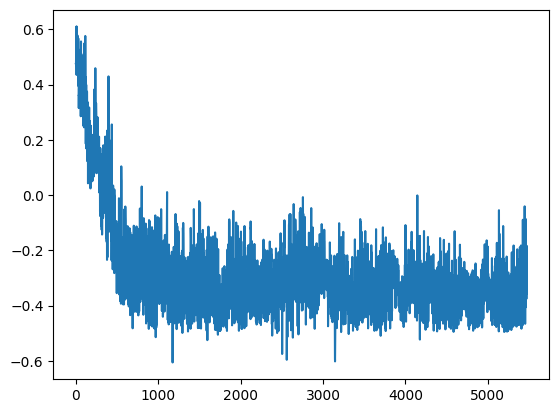

In [51]:
plt.plot(loss_his.sum(axis=1))

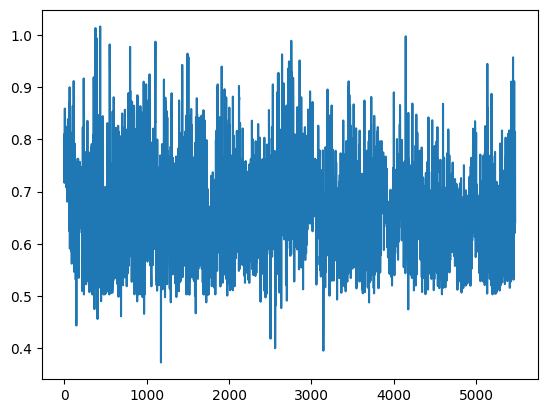

In [52]:
plt.plot(loss_his[:, 0])

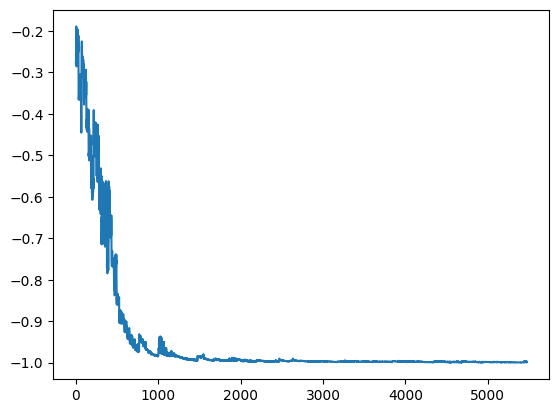

In [53]:
plt.plot(loss_his[:, 1])

In [54]:
mean_iou = evaluate_yolo_clip(
    model=yolo_model,
    clip_model=clip_model,
    clip_processor=clip_processor,
    dataloader=test_loader,
    device=device,
    confidence_threshold=0.01
)

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]

Mean IoU: 0.4047
